In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import os

# Ruta al directorio con las imágenes
directorio_imagenes = '/content/drive/My Drive/Proyecto de Grado G/ProcessedImages_Disc_Exp2'

imagenes_info = []
for filename in os.listdir(directorio_imagenes):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        base = filename.split('_')[0]
        id_paciente = base[3:-2]  # Extrae correctamente el ID del paciente
        tipo_ojo = base[-2:]
        full_path = os.path.join(directorio_imagenes, filename)
        imagenes_info.append({'filename': full_path, 'id': id_paciente, 'eye': tipo_ojo})

imagenes_df = pd.DataFrame(imagenes_info)

# Cargar y preparar los datos clínicos
data_od = pd.read_excel('/content/drive/My Drive/Proyecto de Grado G/patient_data_od.xlsx')
data_os = pd.read_excel('/content/drive/My Drive/Proyecto de Grado G/patient_data_os.xlsx')

data_od['id'] = data_od['Unnamed: 0'].str.replace('#', '').astype(str)
data_os['id'] = data_os['Unnamed: 0'].str.replace('#', '').astype(str)

data_od['eye'] = 'OD'
data_os['eye'] = 'OS'

data_clinica = pd.concat([data_od[['id', 'eye', 'Diagnosis']], data_os[['id', 'eye', 'Diagnosis']]])

full_df = pd.merge(imagenes_df, data_clinica, on=['id', 'eye'], how='left')
full_df = full_df[full_df['Diagnosis'] != 2]  # Asume que quieres excluir los diagnósticos '2'

# Ahora necesitamos preparar los datos para un split estratificado
# Primero, determina la "etiqueta" dominante para cada paciente
dominant_diagnosis = full_df.groupby('id')['Diagnosis'].agg(lambda x: x.mode()[0])

# Crea el dataframe para el split estratificado
patient_df = pd.DataFrame(dominant_diagnosis).reset_index()

# Stratified split en los pacientes
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_patients, test_patients = next(splitter.split(patient_df, patient_df['Diagnosis']))

# Obtén los ID de pacientes para cada conjunto
train_ids = patient_df.iloc[train_patients]['id']
test_ids = patient_df.iloc[test_patients]['id']

# Finalmente, selecciona las filas correspondientes en full_df
train_df = full_df[full_df['id'].isin(train_ids)]
test_df = full_df[full_df['id'].isin(test_ids)]

print("Train DataFrame:")
print(train_df[['filename', 'id', 'eye', 'Diagnosis']].head())

print("\nTest DataFrame:")
print(test_df[['filename', 'id', 'eye', 'Diagnosis']].head())

Train DataFrame:
                                             filename   id eye Diagnosis
2   /content/drive/My Drive/Proyecto de Grado G/Pr...  004  OD         1
3   /content/drive/My Drive/Proyecto de Grado G/Pr...  004  OS         1
4   /content/drive/My Drive/Proyecto de Grado G/Pr...  005  OD         1
5   /content/drive/My Drive/Proyecto de Grado G/Pr...  005  OS         1
14  /content/drive/My Drive/Proyecto de Grado G/Pr...  010  OD         1

Test DataFrame:
                                             filename   id eye Diagnosis
20  /content/drive/My Drive/Proyecto de Grado G/Pr...  015  OD         1
21  /content/drive/My Drive/Proyecto de Grado G/Pr...  015  OS         1
32  /content/drive/My Drive/Proyecto de Grado G/Pr...  023  OD         1
33  /content/drive/My Drive/Proyecto de Grado G/Pr...  023  OS         1
42  /content/drive/My Drive/Proyecto de Grado G/Pr...  028  OD         0


In [5]:
import pandas as pd
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.densenet  import DenseNet121, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_auc_score

In [3]:
from sklearn.utils.class_weight import compute_class_weight

# Calcular los pesos de clases
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['Diagnosis']),
    y=train_df['Diagnosis'].astype(int)
)
class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)

Class weights: {0: 0.6320754716981132, 1: 2.392857142857143}


In [6]:
# Configuración del modelo
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')

29084464/29084464 [==============================] - 2s 0us/step


In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    validation_split = 0.25
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

train_b_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [8]:
# Cambiar el tipo de 'Diagnosis' a string usando .loc para evitar SettingWithCopyWarning
train_df.loc[:, 'Diagnosis'] = train_df['Diagnosis'].astype(str)
test_df.loc[:, 'Diagnosis'] = test_df['Diagnosis'].astype(str)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='Diagnosis',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    subset='training'
)

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='Diagnosis',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    subset='validation'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='Diagnosis',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

train_b_generator = train_b_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='Diagnosis',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 252 validated image filenames belonging to 2 classes.
Found 83 validated image filenames belonging to 2 classes.
Found 84 validated image filenames belonging to 2 classes.
Found 335 validated image filenames belonging to 2 classes.


In [9]:
# Calentamiento del modelo con pesos de clase
checkpoint_path = "best_model_warmup.h5"
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor="val_loss", mode='min', verbose=1)

In [11]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    class_weight=class_weights,
    callbacks=[checkpoint],
)

Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 0.2742
Epoch 1: val_loss improved from inf to 1.40696, saving model to best_model_warmup.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 44s 6s/step - loss: 0.2742 - val_loss: 1.4070
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 0.2489
Epoch 2: val_loss did not improve from 1.40696
8/8 [==============================] - 5s 663ms/step - loss: 0.2489 - val_loss: 1.6585
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 0.2364
Epoch 3: val_loss improved from 1.40696 to 1.37488, saving model to best_model_warmup.h5
8/8 [==============================] - 7s 988ms/step - loss: 0.2364 - val_loss: 1.3749
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 0.2149
Epoch 4: val_loss improved from 1.37488 to 1.32216, saving model to best_model_warmup.h5
8/8 [==============================] - 6s 739ms/step - loss: 0.2149 - val_loss: 1.3222
Epoch 5/50
8/8 [==============================] - ETA: 0s - loss: 0.2048
Epoch 5: val_loss did not improve from 1.32216
8/8 [==============================] - 6s 756ms/step - loss: 0.2048 - val_loss: 1.5254
Epo

3/3 [==============================] - 49s 24s/step
Test set classification report after warmup:
              precision    recall  f1-score   support

     Clase 0       0.80      0.99      0.88        67
     Clase 1       0.00      0.00      0.00        17

    accuracy                           0.79        84
   macro avg       0.40      0.49      0.44        84
weighted avg       0.63      0.79      0.70        84

Test set AUC Score after warmup: 0.5899912203687445
11/11 [==============================] - 5s 499ms/step
Train set classification report after warmup:
              precision    recall  f1-score   support

     Clase 0       0.82      0.99      0.90       265
     Clase 1       0.82      0.20      0.32        70

    accuracy                           0.82       335
   macro avg       0.82      0.59      0.61       335
weighted avg       0.82      0.82      0.78       335

Train set AUC Score after warmup: 0.7138544474393531


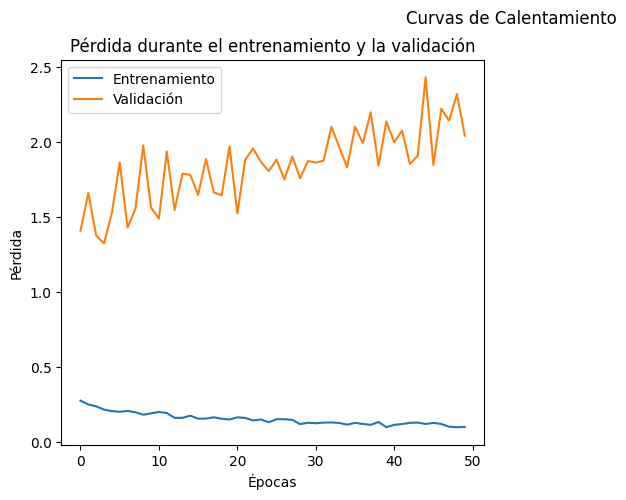

In [12]:
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

predictions_test = model.predict(test_generator)
predicted_classes_test = np.round(predictions_test).astype(int)

y_test = test_generator.classes

print("Test set classification report after warmup:")
print(classification_report(y_test, predicted_classes_test, target_names=['Clase 0', 'Clase 1']))
auc_score_test = roc_auc_score(y_test, predictions_test)
print("Test set AUC Score after warmup:", auc_score_test)

predictions_train = model.predict(train_b_generator, steps=len(train_b_generator), verbose=1)
predicted_classes_train = np.round(predictions_train).astype(int)

y_train = train_b_generator.classes

print("Train set classification report after warmup:")
print(classification_report(y_train, predicted_classes_train, target_names=['Clase 0', 'Clase 1']))
auc_score_train = roc_auc_score(y_train, predictions_train)
print("Train set AUC Score after warmup:", auc_score_train)

def plot_training_curves(history, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Pérdida durante el entrenamiento y la validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.suptitle(title)
    plt.show()

plot_training_curves(history, 'Curvas de Calentamiento')

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model.load_weights("best_model_warmup.h5")

for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy')

# Entrenar el modelo durante el fine-tuning
checkpoint_finetune_path = "best_model_finetune.h5"
checkpoint_finetune = ModelCheckpoint(
    checkpoint_finetune_path,
    save_best_only=True,
    monitor="val_loss",
    mode='min',
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

# Fine-tuning del modelo
history_finetune = model.fit(
    train_generator,
    epochs=200,
    validation_data=valid_generator,
    class_weight=class_weights,
    callbacks=[checkpoint_finetune, early_stopping],
)

Epoch 1/200
8/8 [==============================] - ETA: 0s - loss: 0.2855
Epoch 1: val_loss improved from inf to 1.71053, saving model to best_model_finetune.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 80s 2s/step - loss: 0.2855 - val_loss: 1.7105
Epoch 2/200
8/8 [==============================] - ETA: 0s - loss: 0.2497
Epoch 2: val_loss did not improve from 1.71053
8/8 [==============================] - 8s 905ms/step - loss: 0.2497 - val_loss: 1.8624
Epoch 3/200
8/8 [==============================] - ETA: 0s - loss: 0.2448
Epoch 3: val_loss did not improve from 1.71053
8/8 [==============================] - 6s 742ms/step - loss: 0.2448 - val_loss: 2.0225
Epoch 4/200
8/8 [==============================] - ETA: 0s - loss: 0.2433
Epoch 4: val_loss did not improve from 1.71053
8/8 [==============================] - 7s 890ms/step - loss: 0.2433 - val_loss: 2.0252
Epoch 5/200
8/8 [==============================] - ETA: 0s - loss: 0.2564
Epoch 5: val_loss did not improve from 1.71053
8/8 [==============================] - 6s 715ms/step - loss: 0.2564 - val_loss: 2.1150
Epoch 6/200
8/8 [==============================] - ETA: 0s - loss: 0.2459
Epoch 6: 

3/3 [==============================] - 2s 126ms/step
Test set classification report after fine-tuning:
              precision    recall  f1-score   support

     Clase 0       0.80      1.00      0.89        67
     Clase 1       0.00      0.00      0.00        17

    accuracy                           0.80        84
   macro avg       0.40      0.50      0.44        84
weighted avg       0.64      0.80      0.71        84

Test set AUC Score after fine-tuning: 0.5741878841088673


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


11/11 [==============================] - 2s 135ms/step
Train set classification report after fine-tuning:
              precision    recall  f1-score   support

     Clase 0       0.80      0.98      0.88       265
     Clase 1       0.50      0.09      0.15        70

    accuracy                           0.79       335
   macro avg       0.65      0.53      0.51       335
weighted avg       0.74      0.79      0.73       335

Train set AUC Score after fine-tuning: 0.6893800539083559


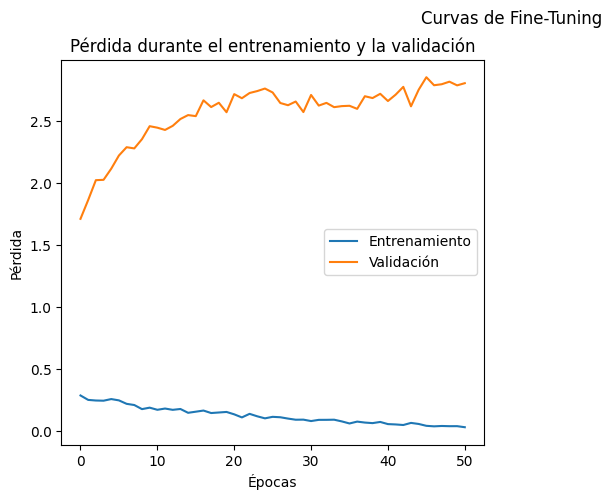

In [14]:
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

# Evaluación del modelo en el conjunto de validación (test_generator) después del calentamiento
predictions_test = model.predict(test_generator)
predicted_classes_test = np.round(predictions_test).astype(int)

y_test = test_generator.classes

print("Test set classification report after fine-tuning:")
print(classification_report(y_test, predicted_classes_test, target_names=['Clase 0', 'Clase 1']))
auc_score_test = roc_auc_score(y_test, predictions_test)
print("Test set AUC Score after fine-tuning:", auc_score_test)

predictions_train = model.predict(train_b_generator, steps=len(train_b_generator), verbose=1)
predicted_classes_train = np.round(predictions_train).astype(int)


y_train = train_b_generator.classes

print("Train set classification report after fine-tuning:")
print(classification_report(y_train, predicted_classes_train, target_names=['Clase 0', 'Clase 1']))
auc_score_train = roc_auc_score(y_train, predictions_train)
print("Train set AUC Score after fine-tuning:", auc_score_train)

import matplotlib.pyplot as plt

def plot_training_curves(history, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Pérdida durante el entrenamiento y la validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.suptitle(title)
    plt.show()


plot_training_curves(history_finetune, 'Curvas de Fine-Tuning')


3/3 [==============================] - 0s 124ms/step


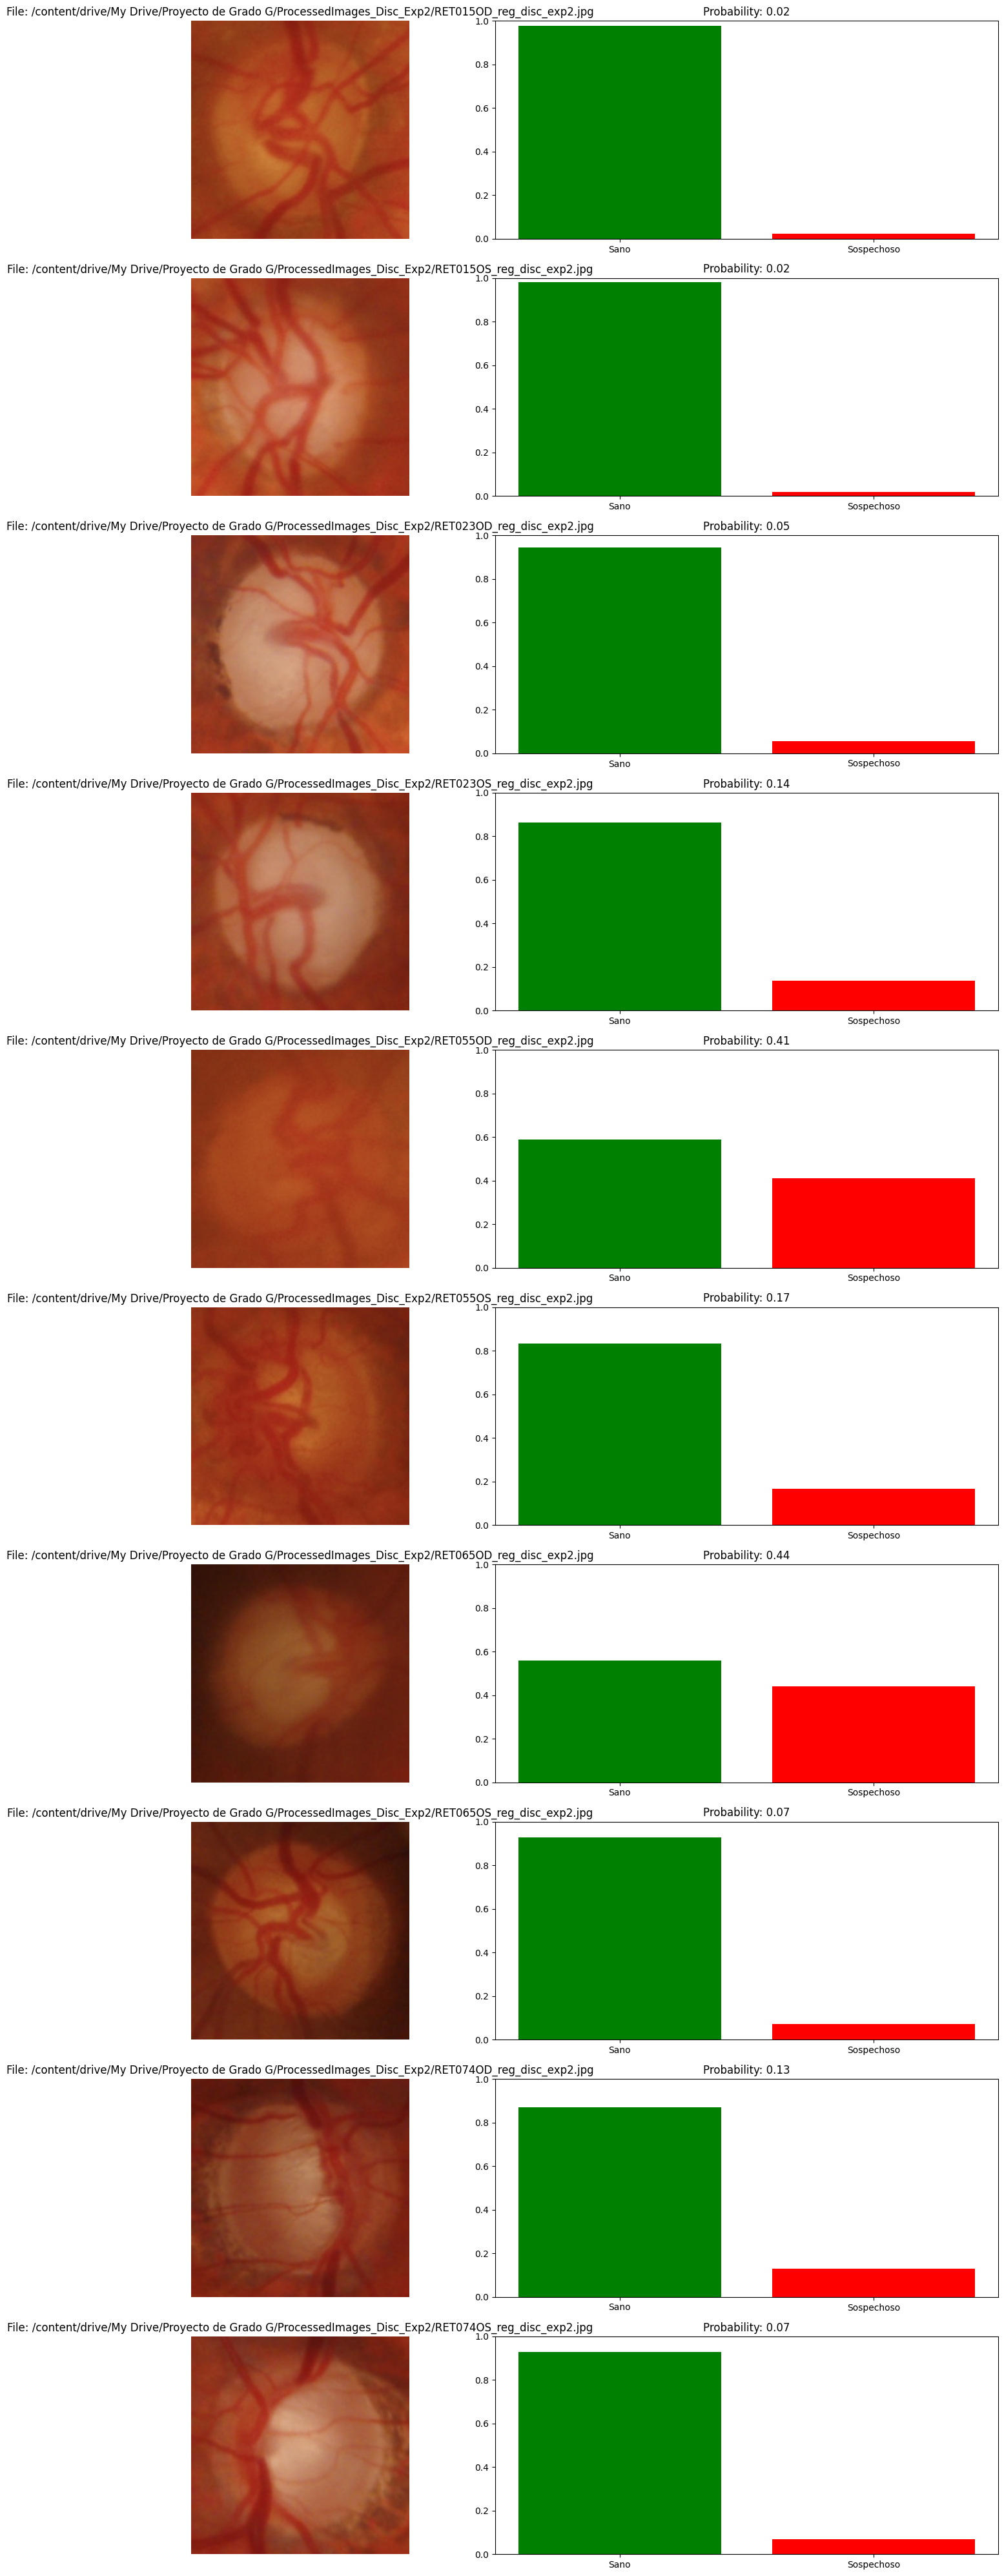

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
import os

# Generar predicciones para las imágenes en el conjunto de prueba
predictions_test = model.predict(test_generator)
probabilities_test = predictions_test.flatten()

# Obtener los nombres de archivo y etiquetas correspondientes a las imágenes de prueba
filenames_test = test_generator.filenames
labels_test = test_generator.classes

# Crear una función para mostrar las imágenes con el nombre de archivo y la probabilidad
def plot_image_with_probability(filenames, probabilities, labels, directory, num_images=10):
    plt.figure(figsize=(15, 40))  # Tamaño ajustado para una mejor visualización
    count = 0
    for i in range(len(filenames)):
        if count >= num_images:
            break
        if labels[i] == 1 or probabilities[i] > 0.5:  # Mostrar imágenes etiquetadas como sospechosas o con alta probabilidad
            img_path = os.path.join(directory, filenames[i])
            img = image.load_img(img_path, target_size=(224, 224))

            # Mostrar imagen
            plt.subplot(num_images, 2, 2 * count + 1)
            plt.imshow(img)
            plt.title(f"File: {filenames[i]}")
            plt.axis('off')

            # Mostrar gráfica de probabilidad
            plt.subplot(num_images, 2, 2 * count + 2)
            plt.bar(['Sano', 'Sospechoso'], [1 - probabilities[i], probabilities[i]], color=['green', 'red'])
            plt.ylim([0, 1])
            plt.title(f"Probability: {probabilities[i]:.2f}")

            count += 1

    plt.tight_layout()
    plt.show()

# Visualizar las primeras 10 imágenes del conjunto de prueba con sus probabilidades
plot_image_with_probability(filenames_test, probabilities_test, labels_test, directorio_imagenes, num_images=10)
